# Score-Based Models
In this notebook, we delve into the fundamentals of score-based models.
Through interactive visualizations, we provide intuitive insights into score-fields, the process of score function training, and sampling methods like Langevin dynamics. This notebook aims to build a deeper understanding of the theoretical underpinnings of the score-based models.

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Generation
Enter your `student_number` below to generate a mixture of gaussian distribution

In [114]:
student_number = 810103322

Generate parameters of mixture of two Gaussians based on the `student_number`.

*Note: This section involves random parameter generation and doesn't require detailed attention.*

In [115]:
# Set random seed
np.random.seed(student_number)

# Mixture coefficients
w1 = 0.15 + np.random.rand() * 0.1
w2 = 1 - w1

# Gaussian placements
if np.random.choice(2):
    mean1, mean2 = [-5, 5], [5, -5]
else:
    mean1, mean2 = [5, 5], [-5, -5]

# Swap dominant
if np.random.choice(2):
    w1, w2 = w2, w1

# Covariance
var1 = 1 + np.random.rand()
var2 = 1 + np.random.rand()

cov1 = [[var1, 0], [0, var1]]
cov2 = [[var2, 0], [0, var2]]


Define the PDF

In [116]:
def gaussian_pdf(x, mean, cov):
    dim = len(mean)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1 / (np.sqrt((2 * np.pi)**dim * det_cov))
    diff = x - mean
    return norm_const * np.exp(-0.5 * diff @ inv_cov @ diff.T)

# Define the PDF function
def p_x(x, y):
    point = np.array([x, y])
    pdf1 = w1 * gaussian_pdf(point, mean1, cov1)
    pdf2 = w2 * gaussian_pdf(point, mean2, cov2)
    return pdf1 + pdf2



Visualization of the Distribution

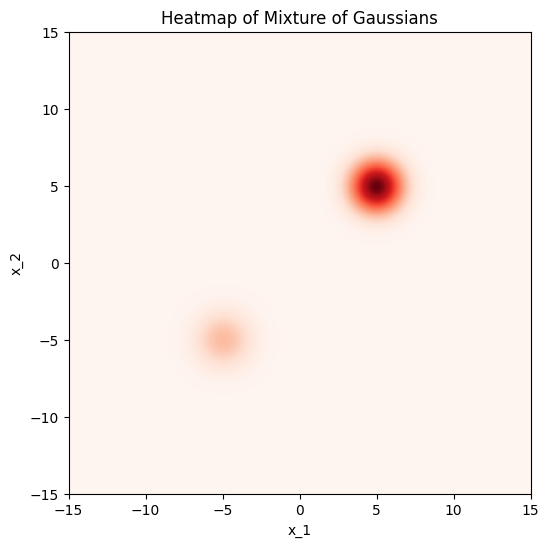

In [117]:
x_min = -15
x_max = 15
y_min = -15
y_max = 15

x, y = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
z = np.array([p_x(xi, yi) for xi, yi in zip(np.ravel(x), np.ravel(y))]).reshape(x.shape)

plt.figure(figsize=(6, 6))

extent = [x_min, x_max, y_min, y_max]

# PDF heatmap with corrected axis
plt.imshow(z, extent=extent, origin="lower", cmap="Reds")
plt.title("Heatmap of Mixture of Gaussians")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

Generate Samples to Create a Toy Dataset

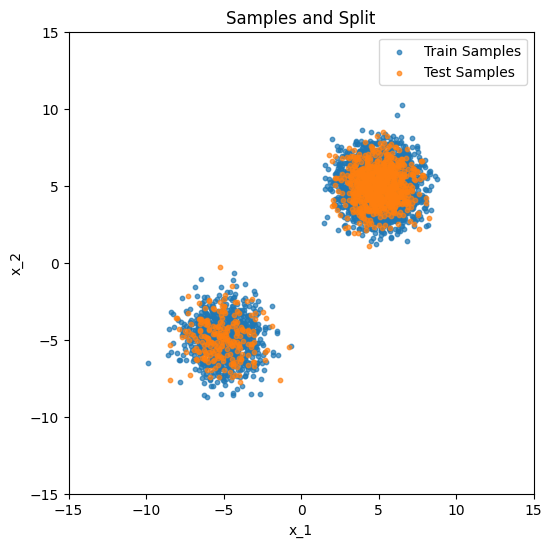

In [118]:
n_samples = 5000
train_split = 0.8
n_train = int(n_samples * train_split)

# Sampling from mixture of Gaussians
n1 = int(n_samples * w1)
n2 = n_samples - n1

samples1 = np.random.multivariate_normal(mean1, cov1, n1)
samples2 = np.random.multivariate_normal(mean2, cov2, n2)

samples = np.vstack((samples1, samples2))

# Shuffle the samples and split
indices = np.random.permutation(n_samples)
train_samples = samples[indices[:n_train]]
test_samples = samples[indices[n_train:]]

# Visualization
plt.figure(figsize=(6, 6))

plt.scatter(train_samples[:, 0], train_samples[:, 1], s=10, alpha=0.7, label="Train Samples")
plt.scatter(test_samples[:, 0], test_samples[:, 1], s=10, alpha=0.7, label="Test Samples")
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.title("Samples and Split")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()


## Score Function (Ground-Truth)
Calculate the ground-truth score function for "Mixture of two Gaussians" analytically and then complete the `#TODO` part.

* You may use `gaussian_pdf(x, mean, cov)` function from the previous section.
* You should also use `w1`, `w2`, `mean1`, `mean2`, `cov1` and `cov2` to implement the `score_function_gt`.

In [119]:
def score_function_gt(x):
    """
      Calculates the score function (gradient of the log-probability) for the mixture of two multivariate Gaussian distributions.
      The mixture is predefined by parameters w1, w2, mean1, mean2, cov1 and cov2.

      Args:
          x: A 2D point where the score function is evaluated.

      Returns:
          numpy.ndarray: The score vector at point x, representing the gradients of
          the log-probability density function of the mixture at those points.

      Notes:
          The score function is derived analytically for the mixture:
          p(x) = w1 * N(x | mean1, cov1) + w2 * N(x | mean2, cov2)
          ∇log(p(x)) = ?
    """

    #####################
    # [TODO 1]
    
    score = 1/p_x(x[0], x[1]) * (w1 * gaussian_pdf(x, mean1, cov1) * -1 * np.linalg.inv(cov1) @ (x-mean1) + w2 * gaussian_pdf(x, mean2, cov2) * -1 * np.linalg.inv(cov2) @ (x-mean2))
    #####################

    return score


Visualization of the Score field

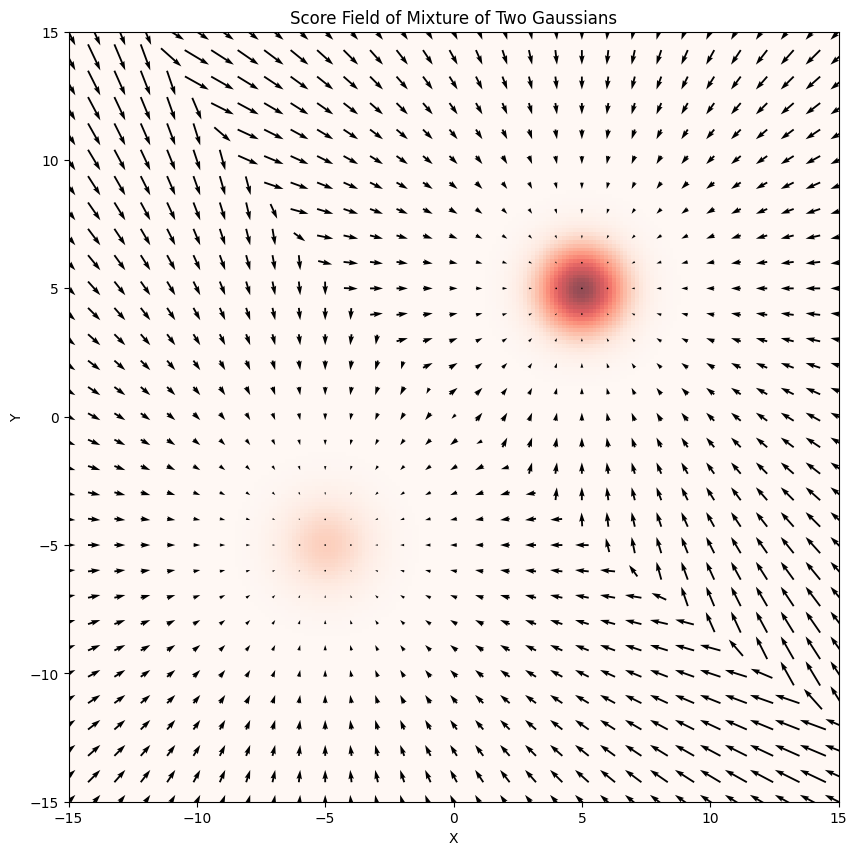

In [120]:
def plot_score_function(score_fn):
    # Mesh grid for the visualization
    x_vals = np.linspace(x_min, x_max, 31)
    y_vals = np.linspace(y_min, y_max, 31)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Calculate score vectors
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            score = score_fn(point)
            U[i, j], V[i, j] = score

    plt.quiver(X, Y, U, V, color="black", pivot="middle")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# Plot the score field
plt.figure(figsize=(10, 10))
plt.imshow(z, extent=extent, origin="lower", cmap="Reds", alpha=0.7)
plt.title("Score Field of Mixture of Two Gaussians")
plot_score_function(score_function_gt)

## Score Matching

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Add Noise

In [122]:
def add_noise(x, sigma):
    """
    Adds Gaussian noise to the input data.

    Args:
        x (torch.Tensor): The input data of shape [batch_size, 2].
        sigma (torch.Tensor): The standard deviation of the Gaussian noise to be added to each input, of shape [batch_size, 1].

    Returns:
        tuple:
            - x_noisy (torch.Tensor): The noisy data of the same shape as the input.
            - epsilon (torch.Tensor): The Gaussian noise added to the input, of the same shape as x.

    Notes:
        The function perturbs the input data `x` by adding Gaussian noise drawn from
        N(0, sigma²I) to create a noisy version of the data. Both the noisy data and the noise
        used are returned.
    """
    #####################
    # [TODO 2.1]

    epsilon = torch.randn_like(x) * sigma 
    x_noisy = x + epsilon

    #####################

    return x_noisy, epsilon

Loss Function

In [123]:
def score_matching_loss(noise, pred_score, sigma):
    """
    Calculates the score matching loss for a batch of noisy data points using noise perturbation.

    Args:
        inputs: A placeholder for the required inputs.
                You should determine the necessary inputs.
                Expected input dimensions: [batch_size, ...].

    Returns:
        The computed loss value for the given batch.
    """

    #####################
    # [TODO 2.2]

    loss = torch.sum(torch.norm(pred_score + (1/sigma**2) * noise, p = 2)**2)

    #####################

    return loss

Training loop

In [124]:
def train_score_model(model, data, sigma_range, epochs=100, learning_rate=0.01):
    """
    Trains the score-based model over a range of sigma values using score matching loss.

    Args:
        model (torch.nn.Module): The score-based model to train.
        data (torch.Tensor): Training data, of shape [num_samples, 2].
        sigma_range (tuple): Range of sigma values to use during training, specified as [min_sigma, max_sigma].
        epochs (int, optional): Number of training epochs.
        learning_rate (float, optional): Learning rate for the optimizer.

    Returns:
        torch.Tensor: A batch of noisy data generated during training, for visualization purposes.

    Notes:
        - The model learns to predict the score function for noisy samples across a range of sigma values.
        - Uses uniform sampling of sigma values within the specified range during training.
        - Computes the score matching loss for each batch and updates the model parameters accordingly.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        epoch_loss = 0

        x_batch = data

        #####################
        # [TODO 2.3]

        # Generate sigma values uniformly within the specified range for each data point. shape: [num_samples, 1]
        sigma = (sigma_range[1] - sigma_range[0]) * torch.rand(len(x_batch), 1) + sigma_range[0]

        # Add noise to the data points using sampled sigma values
        x_noisy, epsilon = add_noise(x_batch, sigma)

        # Predict the score function using the model
        outputs = model(x_noisy, sigma)

        # Compute the score matching loss
        loss = score_matching_loss(epsilon, outputs, sigma)

        #####################

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Log epoch loss
        if((epoch+1)%10==0): print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data)}")

    # return a batch of noisy data for visualization purposes
    return x_noisy


### Model Architecture

In [125]:
class ScoreNet(nn.Module):
    def __init__(self):
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x, sigma):
        x_sigma = torch.cat([x, sigma], dim=1)
        return self.net(x_sigma)


In [126]:
# Helper function for visualization purposes
def visualize_score_field_model(model, samples=None, sigma=1, title="",):
    def fn(point):
        with torch.no_grad():
          pred = tuple(model(torch.tensor(point, dtype=torch.float).unsqueeze(0), torch.tensor([[sigma]])).squeeze().detach().numpy())
        return pred
    plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=15, density=True, range=[[x_min,x_max],[y_min, y_max]])
    plt.imshow(heatmap.T, extent=extent, origin="lower", cmap="Reds", interpolation="bilinear", alpha=0.7)
    # plt.scatter(samples[:, 0], samples[:, 1], s=1)
    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    plt.title(title)
    plot_score_function(fn)

### Train Score matching with Constant Sigma

In [127]:
train_data = torch.tensor(train_samples).to(torch.float)

Example for sigma = 1

Epoch 10/100, Loss: 1.7317274169921875
Epoch 20/100, Loss: 1.499174072265625
Epoch 30/100, Loss: 1.4154169921875
Epoch 40/100, Loss: 1.3663148193359376
Epoch 50/100, Loss: 1.1789329833984374
Epoch 60/100, Loss: 1.163662353515625
Epoch 70/100, Loss: 1.2104744873046875
Epoch 80/100, Loss: 1.184965576171875
Epoch 90/100, Loss: 1.190148193359375
Epoch 100/100, Loss: 1.181315185546875


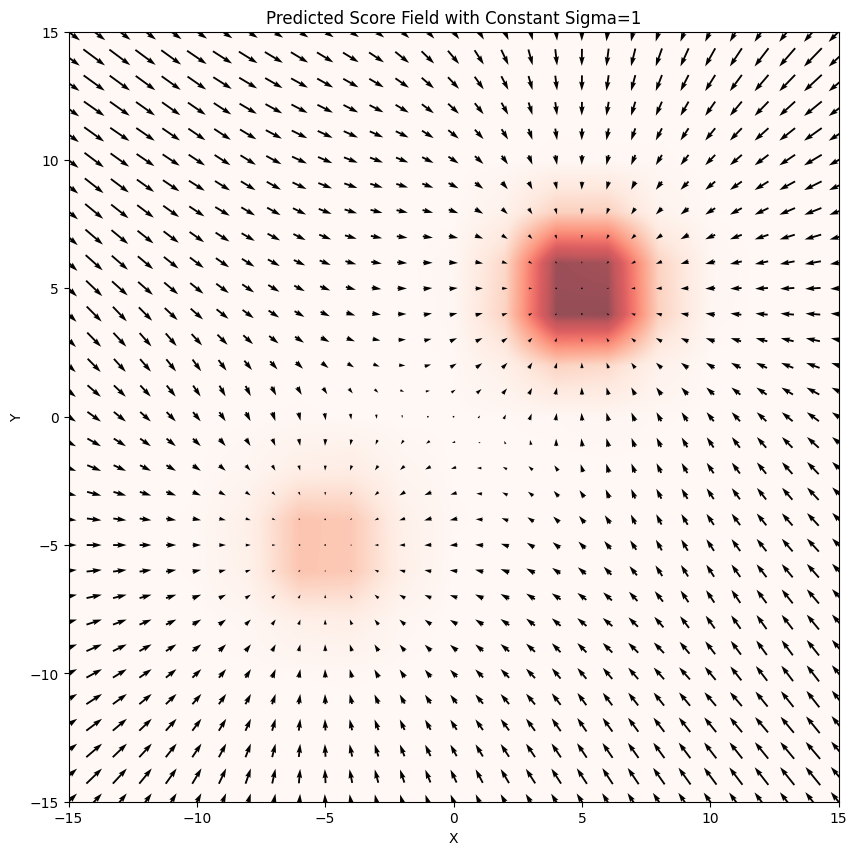

In [128]:
model_const_sigma_1 = ScoreNet()
samples = train_score_model(model_const_sigma_1, train_data, sigma_range=[1, 1])
visualize_score_field_model(model_const_sigma_1, samples, sigma=1, title="Predicted Score Field with Constant Sigma=1")

Epoch 10/100, Loss: 0.09938065338134766
Epoch 20/100, Loss: 0.07088506317138672
Epoch 30/100, Loss: 0.05765631103515625
Epoch 40/100, Loss: 0.050589889526367185
Epoch 50/100, Loss: 0.05222389602661133
Epoch 60/100, Loss: 0.04889396667480469
Epoch 70/100, Loss: 0.050764965057373046
Epoch 80/100, Loss: 0.04854220581054688
Epoch 90/100, Loss: 0.04653404235839844
Epoch 100/100, Loss: 0.04933056259155273


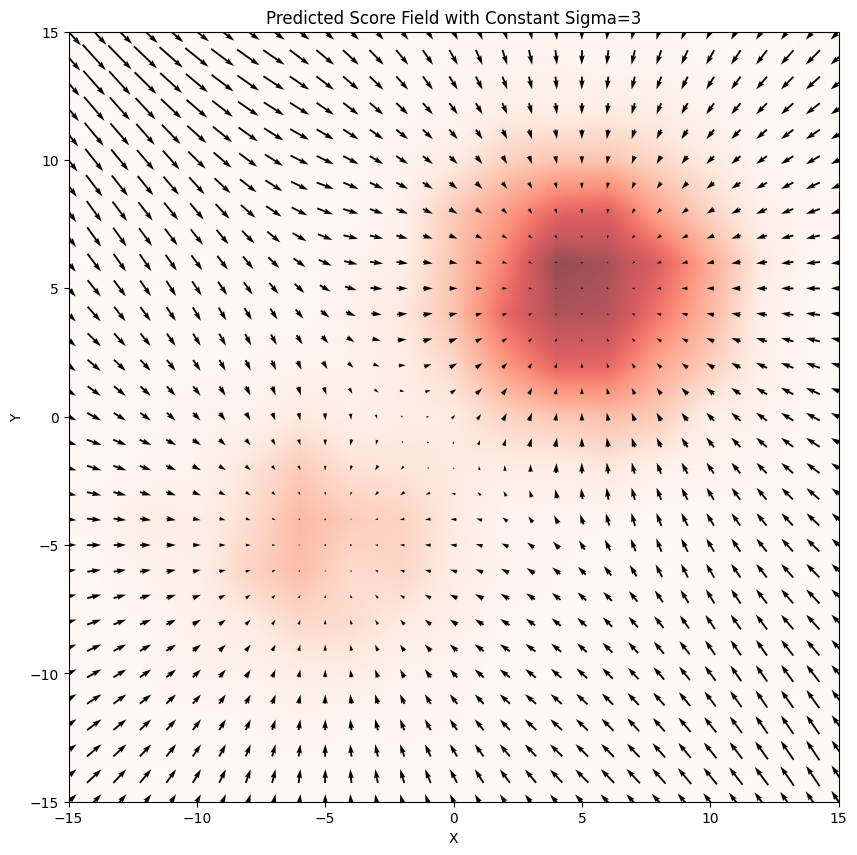

In [129]:
model_const_sigma_3 = ScoreNet()
samples = train_score_model(model_const_sigma_3, train_data, sigma_range=[3, 3])
visualize_score_field_model(model_const_sigma_3, samples, sigma=3, title="Predicted Score Field with Constant Sigma=3")

Epoch 10/100, Loss: 0.029775609970092775
Epoch 20/100, Loss: 0.01595283508300781
Epoch 30/100, Loss: 0.012004738807678222
Epoch 40/100, Loss: 0.01061775016784668
Epoch 50/100, Loss: 0.00994481086730957
Epoch 60/100, Loss: 0.009013686180114746
Epoch 70/100, Loss: 0.008777850151062012
Epoch 80/100, Loss: 0.009014697074890136
Epoch 90/100, Loss: 0.008965814590454101
Epoch 100/100, Loss: 0.008519915580749512


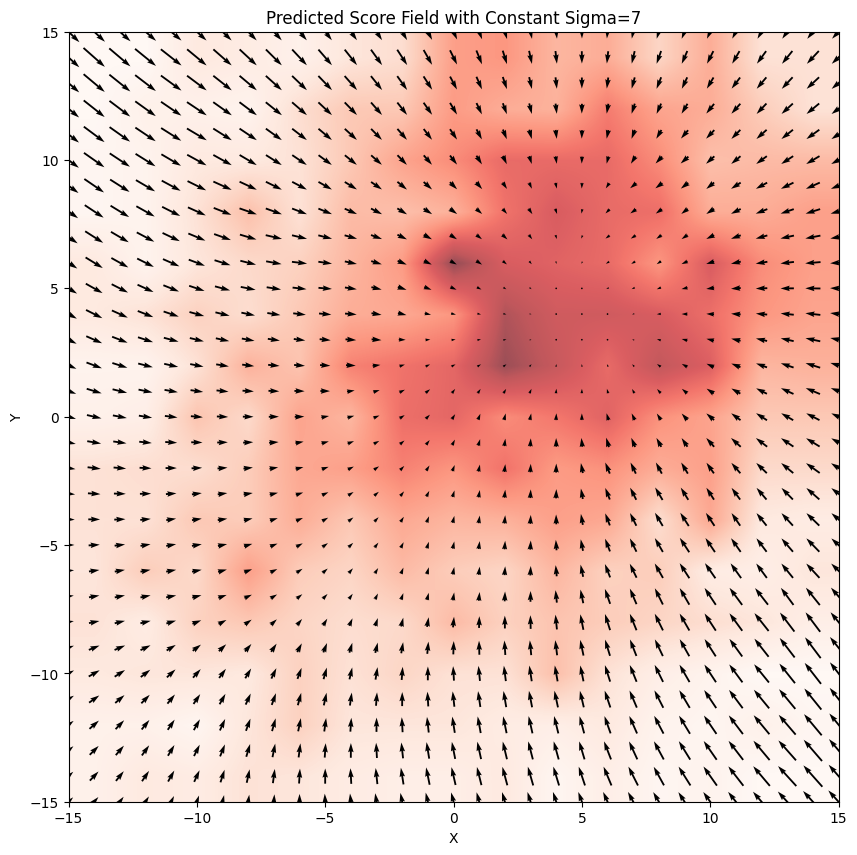

In [130]:
model_const_sigma_7 = ScoreNet()
samples = train_score_model(model_const_sigma_7, train_data, sigma_range=[7, 7])
visualize_score_field_model(model_const_sigma_7, samples, sigma=7, title="Predicted Score Field with Constant Sigma=7")

## Sampling

In [131]:
num_steps = 10
step_size = 1

### Two Methods for Sampling

In [132]:
def deterministic_sampling(model, start_point, sigma_t, step_size, num_steps):
    """
    Performs deterministic sampling based on the score function model.

    Args:
        model (torch.nn.Module): The trained score function model.
        start_point (torch.Tensor): The initial points for sampling, of shape [batch_size, 2].
        sigma_t (torch.Tensor): A tensor of noise scales for each step, of shape [num_steps, batch_size, 1].
        step_size (float): The step size for moving in the direction of the score function.
        num_steps (int): The number of steps to perform.

    Returns:
        list[torch.Tensor]: A list of tensors representing the trajectory of points at each step.

    Notes:
        The trajectory is computed by moving the points in the direction of the score function
        gradient at each step without adding randomness.
    """
    current_point = start_point.detach()
    trajectory = [current_point]
    #####################
    # [TODO 3.2]
    with torch.inference_mode():
        for i in range(num_steps):
            score = model(current_point, torch.full((current_point.shape[0], 1),sigma_t[i].item()))
            # score = score / torch.norm(score, p=2)
            step = step_size * score
            current_point += step
            trajectory.append(current_point.clone())
            
    #####################
    return trajectory


def langevin_sampling(model, start_point, sigma_t, step_size, num_steps):
    """
    Performs Langevin dynamics sampling based on the score function model.

    Args and Outputs similar to the previous function.

    Notes:
        The trajectory is computed by moving the points in the direction of the score function
        gradient at each step, with added Gaussian noise with a specific scale to introduce stochasticity.
    """
    current_point = start_point.detach()
    trajectory = [current_point]
    #####################
    # [TODO 3.2]
    with torch.inference_mode():
        for i in range(num_steps):
            score = model(current_point, torch.full((current_point.shape[0], 1),sigma_t[i].item()))
            # score = score / torch.norm(score, p=2)
            step = step_size * score
            current_point += step + 0.8 * torch.randn_like(step)
            trajectory.append(current_point.clone())
    #####################
    return trajectory




In [133]:
start_point = torch.rand(1,2) * (x_max-x_min) + x_min

deterministic_traj = deterministic_sampling(model_const_sigma_1, start_point.clone(), torch.ones(num_steps, 1, 1), step_size, num_steps)
langevin_traj = langevin_sampling(model_const_sigma_1, start_point.clone(), torch.ones(num_steps, 1, 1), step_size, num_steps)

Visualization

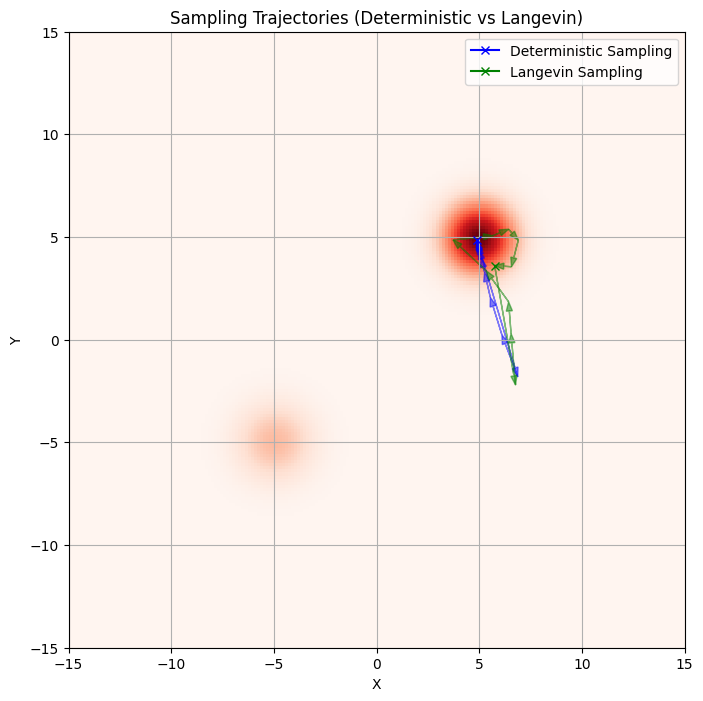

In [134]:

# Convert trajectories to arrays
deterministic_traj = np.concatenate(deterministic_traj, axis=0)
langevin_traj = np.concatenate(langevin_traj, axis=0)


plt.figure(figsize=(8, 8))

# Plot deterministic trajectory
plt.plot(deterministic_traj[-1, 0], deterministic_traj[-1, 1], marker="x", color="blue", label="Deterministic Sampling")
for i in range(len(deterministic_traj) - 1):
    plt.arrow(deterministic_traj[i, 0], deterministic_traj[i, 1],
              deterministic_traj[i + 1, 0] - deterministic_traj[i, 0],
              deterministic_traj[i + 1, 1] - deterministic_traj[i, 1],
              color="blue", head_width=0.3, length_includes_head=True, alpha=0.5)

# Plot Langevin trajectory
plt.plot(langevin_traj[-1, 0], langevin_traj[-1, 1], marker="x", color="green", label="Langevin Sampling")
for i in range(len(langevin_traj) - 1):
    plt.arrow(langevin_traj[i, 0], langevin_traj[i, 1],
              langevin_traj[i + 1, 0] - langevin_traj[i, 0],
              langevin_traj[i + 1, 1] - langevin_traj[i, 1],
              color="green", head_width=0.3, length_includes_head=True, alpha=0.5)


plt.legend()
plt.imshow(z, extent=extent, origin="lower", cmap="Reds")
plt.title("Sampling Trajectories (Deterministic vs Langevin)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.grid(True)
plt.show()


### Generate 1000 samples with each method
*Note: Sample all starting points at once, or it’s gonna take ages!*

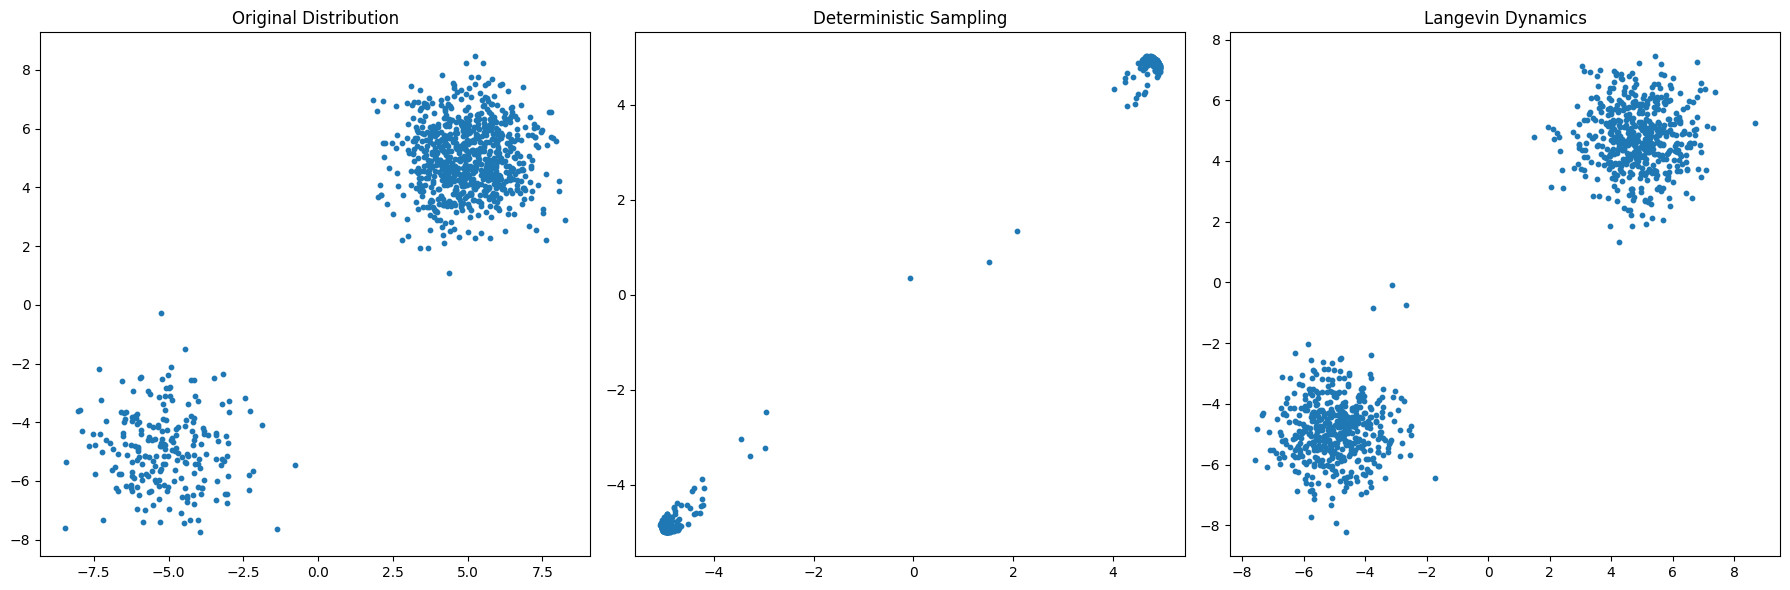

In [135]:
#####################
# [TODO 4]

deterministic_samples = torch.rand(1000,2) * (x_max-x_min) + x_min
langevin_samples = torch.rand(1000,2) * (x_max-x_min) + x_min

deterministic_samples = deterministic_sampling(model_const_sigma_1, deterministic_samples.clone(), torch.ones(num_steps, 1, 1), step_size, num_steps)[-1]
langevin_samples = langevin_sampling(model_const_sigma_1, langevin_samples.clone(), torch.ones(num_steps, 1, 1), step_size, num_steps)[-1]

#####################


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(test_samples[:, 0], test_samples[:, 1], s=10)
axes[0].set_title("Original Distribution")

axes[1].scatter(deterministic_samples[:, 0], deterministic_samples[:, 1], s=10)
axes[1].set_title("Deterministic Sampling")

axes[2].scatter(langevin_samples[:, 0], langevin_samples[:, 1], s=10)
axes[2].set_title("Langevin Dynamics")

plt.tight_layout()
plt.show()

## Final Part

### Score matching with different values for sigma
Train a score-based model using a range of sigma values (e.g., [1, 20]) during training, using the functions developed in previous sections.

*Note: You may need to increase the number of epochs for effective training.*

Epoch 10/2000, Loss: 0.28082363891601564
Epoch 20/2000, Loss: 0.10444078063964844
Epoch 30/2000, Loss: 0.1109942398071289
Epoch 40/2000, Loss: 0.09632674407958984
Epoch 50/2000, Loss: 0.09092842864990235
Epoch 60/2000, Loss: 0.0904347915649414
Epoch 70/2000, Loss: 0.09008522033691406
Epoch 80/2000, Loss: 0.08122284698486328
Epoch 90/2000, Loss: 0.06532021331787109
Epoch 100/2000, Loss: 0.07914156341552735
Epoch 110/2000, Loss: 0.07064985656738282
Epoch 120/2000, Loss: 0.06722815704345703
Epoch 130/2000, Loss: 0.06111634063720703
Epoch 140/2000, Loss: 0.06469834899902344
Epoch 150/2000, Loss: 0.06471833038330078
Epoch 160/2000, Loss: 0.07314497375488281
Epoch 170/2000, Loss: 0.06519599914550782
Epoch 180/2000, Loss: 0.0588763313293457
Epoch 190/2000, Loss: 0.05571269607543945
Epoch 200/2000, Loss: 0.05744070053100586
Epoch 210/2000, Loss: 0.05554437255859375
Epoch 220/2000, Loss: 0.05824882125854492
Epoch 230/2000, Loss: 0.06136985397338867
Epoch 240/2000, Loss: 0.05706697082519531
Epoc

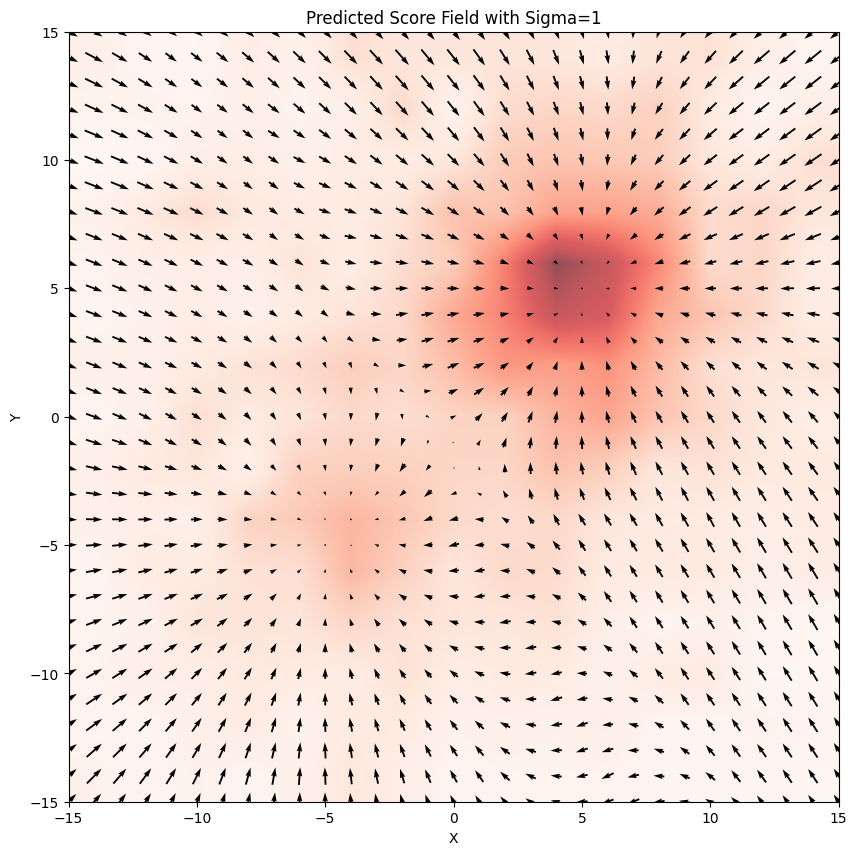

In [136]:
#####################
# [TODO 5.1]

model_dynamic_sigma = ScoreNet()
samples = train_score_model(model_dynamic_sigma, train_data, sigma_range=[1, 20], epochs=2000)
visualize_score_field_model(model_dynamic_sigma, samples, sigma=1, title="Predicted Score Field with Sigma=1")

#####################

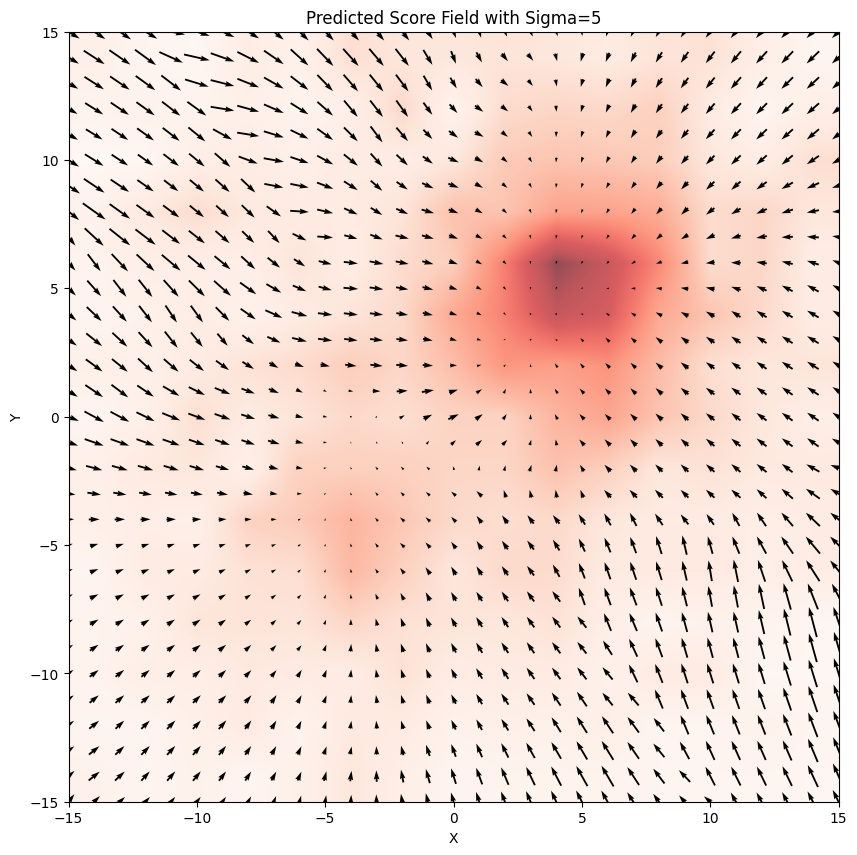

In [137]:
visualize_score_field_model(model_dynamic_sigma, samples, sigma=5, title="Predicted Score Field with Sigma=5")

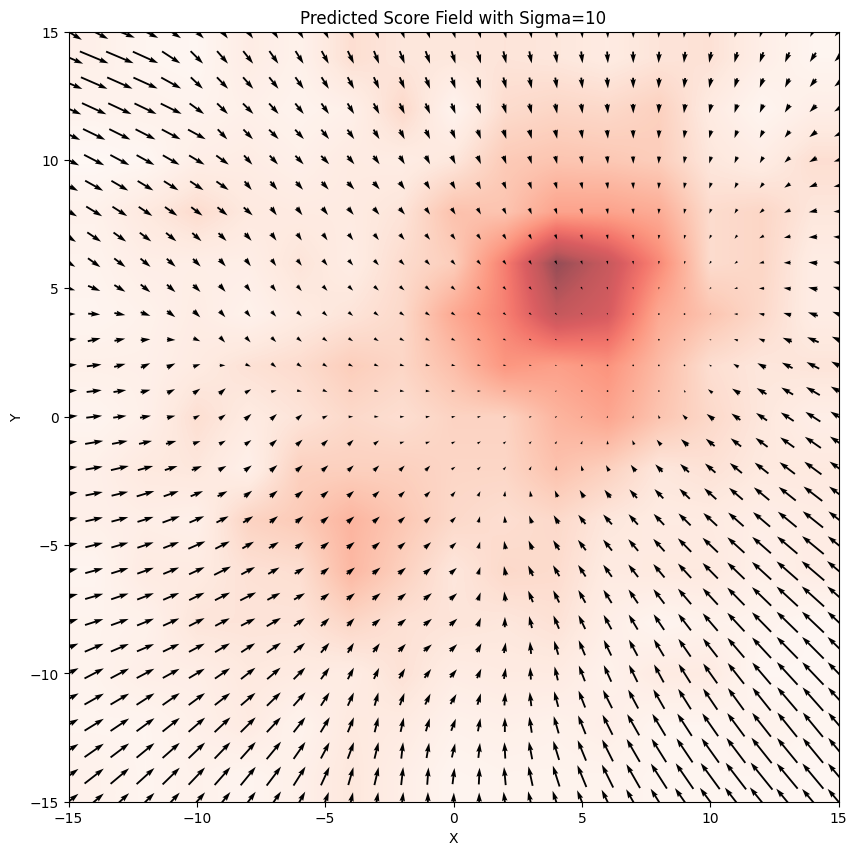

In [138]:
visualize_score_field_model(model_dynamic_sigma, samples, sigma=10, title="Predicted Score Field with Sigma=10")

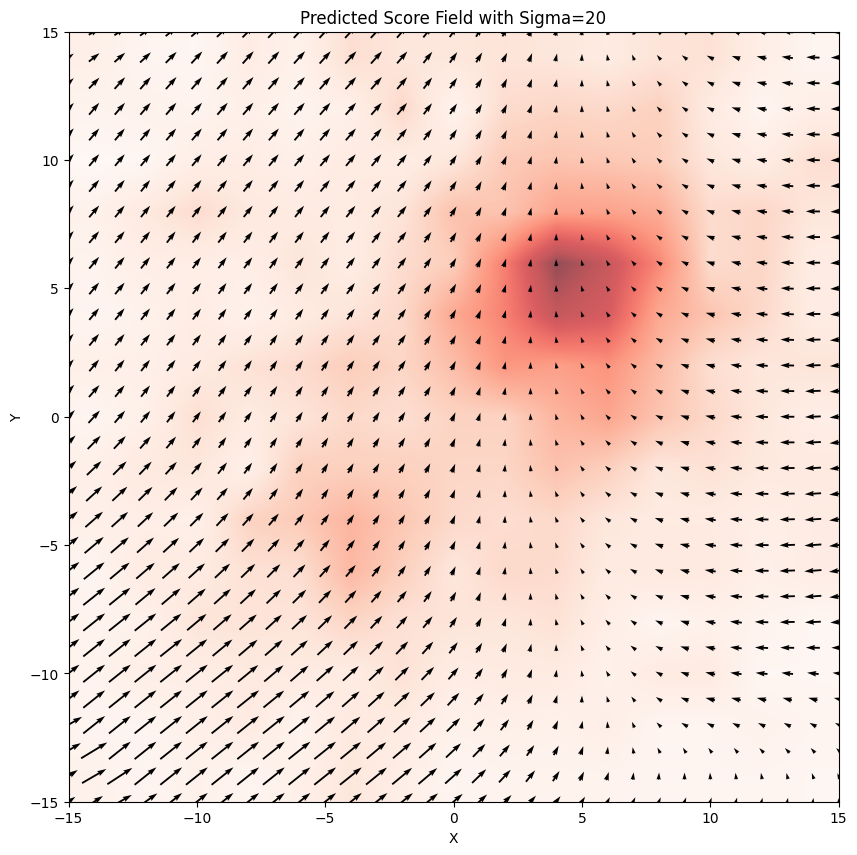

In [139]:
visualize_score_field_model(model_dynamic_sigma, samples, sigma=20, title="Predicted Score Field with Sigma=20")

### Sampling with Noise Schedule
Apply the sampling methods implemented earlier, using a sigma schedule. Begin with a high sigma value and progressively decrease it over the sampling steps.

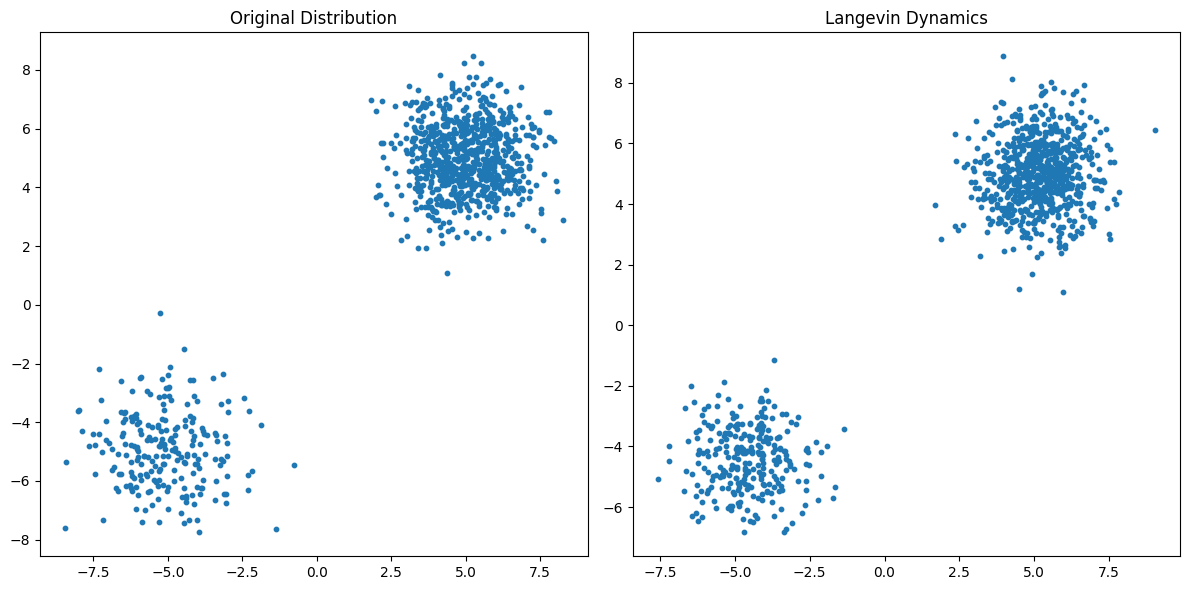

In [140]:
#####################
# [TODO 5.2]

num_steps = 10
tensors = [torch.full((num_steps, 1, 1), fill_value=float(i)) for i in range(20, 0, -1)]
sigma_t = torch.cat(tensors, dim=0)

samples_ld = torch.rand(1000,2) * (x_max-x_min) + x_min
samples_ld = langevin_sampling(model_dynamic_sigma, samples_ld.clone(), sigma_t, step_size, num_steps * 20)[-1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(test_samples[:, 0], test_samples[:, 1], s=10)
axes[0].set_title("Original Distribution")

axes[1].scatter(samples_ld[:, 0], samples_ld[:, 1], s=10)
axes[1].set_title("Langevin Dynamics")

plt.tight_layout()
plt.show()

#####################